In [34]:
from IPython.display import display, display_markdown
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score

# Prediction of Tanzanian water pumps functional status

This study will focus on identifying the functional status (functional, needs repair or non-functional) of Tanzanian water pumps. The possible explanatory variables will be location, construction year, funder, type of extraction, water quality and quantity, population using it and management organization.

I picked up this challenge from the [DrivenData](https://www.drivendata.org/) competitions list because it shows a direct and pratical application of how statistical analysis can help improve services and products quality. And as an engineer, those goals will be definitely the basis of any data science case I will have to solve. Moreover, as lots of possible explanatory variables are available, this will give me the chance to apply advance tools I learnt during the [Data Analysis and Interpretation online Specialization](https://www.coursera.org/specializations/data-analysis).

Predicting accurately the water pumps functional status will help planning maintenance earlier. That in turn will increase the availability of the water point and thus the quality of life for the people depending on those water supplies.

## Methods

### Sample

The database contains 74,250 records of water points information from the Tanzania Ministry of Water. The records were made between October 2002 and December 2013. Unfortunately there are no clear explanation on the techniques used to collect those data.

In [6]:
training_data = pd.read_csv('training_set_values.csv', index_col=0)
training_label = pd.read_csv('training_set_labels.csv', index_col=0)

test_data = pd.read_csv('test_set_values.csv', index_col=0)

# Merge test data and training data to apply same data management operations on them
data = training_data.append(test_data).sort_index()

### Measures

The functional status of the water points are categorized in three groups: functional, functional needs repair and non functional. As the response variable contains more than 2 categories, two new dichotomic variables will be created by collapsing the three existing categories :
- *functional* : 1 for functional and functional needs repair waterpoints and 0 for non functional waterpoints.
- *no repair* : 1 for functional waterpoints and 0 for the others.

The potential predictors will be:

- The amount of water available; missing data are coded as 0, they will be replaced by the mean value to suppress minimum amount of data.
- The organization having funded the well

From the various actors, the following categories will be created :

    'organisation' : ('bank', 'msf', 'wwf', 'unicef', 'unisef', 'oxfam', 'oxfarm', 'rotary club', 'lion's club', 'care', 'without', 'action contre la faim', 'rain', 'red cross', 'blue angels', 'fundat', 'foundation'),
    'church' : ('church', 'churc', 'rcchurch', 'roman', 'missionsry', 'lutheran', 'islamic', 'islam', 'vision'),
    'private' : ('consulting', 'engineer', 'private', 'ltd', 'co.ltd', 'contractor', 'enterp', 'enterpr', 'company', 'contract'),
    'community' : ('village', 'community', 'communit', 'district', 'council', 'commu', 'villigers', 'villagers'),
    'government' : ('government', 'gov', 'govt', 'gover', 'gove', 'governme', 'ministry'),
    'other' : ('0', 'nan', 'known', 'other', 'unknown'),
    'danida' : ('danida', 'danid'),
    'foreign government' : ('netherlands', 'germany', 'european')
    
Then the 9 most funders will be kept and the others will be gathered in the `other` category.

- The installer of the well; the grouping technique applied on the funders will be applied on the installer categories.
- The GPS coordinates (height, longitude and latitude); missing data are coded as 0, they will be coded as NaN except for the height for which the missing data will be replaced by the mean values to keep a maximum of records for the analysis.
- The geographic water basin
- The geographic region
- The population around the well; missing data are coded as 0, they will be coded as NaN.
- Organization of public meeting at the water point; dichotomic variable (True/False)
- The operator of the waterpoint
- The management of the waterpoint
- Is the waterpoint is permitted?
- Year the waterpoint was constructed; missing data are coded as 0, they will be replaced by the median value to avoid discarding a lot of records in the analysis.
- The kind of extraction the waterpoint uses
- How payment are handled?
- The quality of the water
- The quantity of the water
- The source of the water
- The type of water point

As the Python package `sklearn` cannot handle non-binary categorical variables, those variables will be expanded in as much new dichotomic variables as there are categories. Therefore the number of potential explanatory variables will be huge. So as a prepocess steps, a random forest test will be carried out to select only the variables having a substantial effect.

In [11]:
# As lots of waterpoints are missing a value for amount_tsh. For that field the missing
# data will be replaced by the mean data to drop less data for the model fit
imp = preprocessing.Imputer(missing_values=0, strategy='mean')
imp.fit(data['amount_tsh'].values.reshape(-1, 1))
data['water_amount'] = imp.transform(data['amount_tsh'].values.reshape(-1, 1)).ravel()

imp = preprocessing.Imputer(missing_values=0, strategy='median')
imp.fit(data['construction_year'].values.reshape(-1, 1))
data['construction_year'] = imp.transform(data['construction_year'].values.reshape(-1, 1)).ravel()

imp = preprocessing.Imputer(missing_values=0, strategy='mean')
imp.fit(data['gps_height'].values.reshape(-1, 1))
data['height'] = imp.transform(data['gps_height'].values.reshape(-1, 1)).ravel()

# Recode missing data as NaN
for field in ('longitude', 'latitude'):
    data[field] = data[field].map(lambda x: x if x else pd.np.nan)

def group_installer(data):
    def gather_installer(x):
        installer_map = {
            'organisation' : ('bank', 'msf', 'wwf', 'unicef', 'unisef', 'oxfam', 'oxfarm', 'club', 'care', 'without', 'faim', 'rain', 'red', 'angels', 'fundat', 'foundation'),
            'church' : ('church', 'churc', 'rcchurch', 'roman', 'missionsry', 'lutheran', 'islamic', 'islam', 'vision'),
            'private' : ('consulting', 'engineer', 'private', 'ltd', 'co.ltd', 'contractor', 'enterp', 'enterpr', 'company', 'contract'),
            'community' : ('village', 'community', 'communit', 'district', 'council', 'commu', 'villigers', 'villagers'),
            'government' : ('government', 'gov', 'govt', 'gover', 'gove', 'governme', 'ministry'),
            'other' : ('0', 'nan', 'known', 'other', 'unknown'), # Group 'unknown' data with 'other' as finally this means the same for interpretation
            'danida' : ('danida', 'danid'),
            'foreign government' : ('netherlands', 'germany', 'european')
        }

        for substr in x.split():
            for subsubstr in substr.split('/'):
                for key in installer_map:
                    if subsubstr in installer_map[key]:
                        return key

        return x
    
    lower_data = data.map(lambda x: str(x).lower())
    tmp_data = lower_data.map(gather_installer)
    top10 = list(tmp_data.value_counts()[:10].index)
    
    return tmp_data.map(lambda x: x if x in top10 else 'other')

data['installer'] = group_installer(data.installer)
data['funder'] = group_installer(data.funder)

clean_data = (data.iloc[training_data.index]
                  .join(training_label['status_group'])
                  .dropna())
# Create two columns one collapsing 'functional' and 'functional needs repair'
# and the other one collapsing 'non functional' and 'functional needs repair'
clean_data['functional'] = clean_data['status_group'].map({'functional' : 1, 
                                                           'functional needs repair' : 1,
                                                           'non functional' : 0})
clean_data['no_repairs'] = clean_data['status_group'].map({'functional' : 1, 
                                                           'functional needs repair' : 0,
                                                           'non functional' : 0})

In [12]:
# Extract predictors and convert categorical variables in dichotomic variables
predictors_name = ['water_amount', 'height', 'longitude', 'latitude',
                   'basin', 'region', 'population', 'public_meeting', 'management_group',
                   'permit', 'construction_year', 'extraction_type_class', 'payment_type',
                   'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group',
                   'installer', 'funder']

categorical_predictors = ('basin', 'region', 'management_group', 'extraction_type_class', 
                          'payment_type', 'quality_group', 'quantity_group', 
                          'source_type', 'waterpoint_type_group', 'installer', 'funder')

process_data = pd.DataFrame()
for name in predictors_name:
    if name in categorical_predictors:
        classes = data[name].unique()
        deployed_categories = preprocessing.label_binarize(data[name], classes=classes)
        # Avoid class name collision
        classe_names = list()
        for c in classes:
            if c in process_data.columns:
                classe_names.append('_'.join((c, name)))
            else:
                classe_names.append(c)
        
        tmp_df = pd.DataFrame(deployed_categories, 
                              columns=classe_names, 
                              index=data.index)
        process_data = process_data.join(tmp_df)
    else:
        process_data[name] = data[name]

predictors_columns = process_data.columns
        
deployed_data = (process_data.iloc[training_data.index]
                             .join(training_label['status_group'])
                             .dropna())
# Create two columns one collapsing 'functional' and 'functional needs repair'
# and the other one collapsing 'non functional' and 'functional needs repair'
deployed_data['functional'] = deployed_data['status_group'].map({'functional' : 1, 
                                                                 'functional needs repair' : 1,
                                                                 'non functional' : 0})
deployed_data['no_repairs'] = deployed_data['status_group'].map({'functional' : 1, 
                                                                 'functional needs repair' : 0,
                                                                 'non functional' : 0})

predictors = deployed_data[predictors_columns]

### Analyses

The distributions of the response and explanatory variables will be evaluated by looking at the frequency tables for categorical variables and by calculating statistical values (mean, standard deviation, minimum and maximum) for quantitative variables.

The reponse variable being categorical, bivariate associations will be visualized using bar charts after collapsing categories if needed. And the possible bivariate associations will be tested using Chi-Square test.

The random forest method will be applied to identify the best subset of predictors. The DrivenData competition has split the database in a training set containing 80% of the records and 20% are kept for testing by submission on the website. As multiple submissions are allowed for the competition, the accuracy of the model will be tested by submitting the prediction carried out on the test data.

## Results

### Explanatory variable selection

First a Random Tree test was performed to limit the number of explanatory variables. From that first analysis (see the table below), the following explanatory variables are kept:
- The position of the longitude, latitude and height of the waterpoint
- The quantity of water available
- The population size next to the waterpoint
- The year of construction
- If a permit was issued or not for the waterpoint
- The type of extraction
- The water point type
- The payment methods

The primary consequences is althought gps positions are important the administration division (like geographic region) have less importance. It seems also than the way the waterpoint was funded and installed and how it is managed are not of great importances. Some natural guesses like the quantity, the population living around and the year of construction come forward in the random forest test.

In [13]:
# fit an Extra Trees model to the data and look at the first 15 important fields
model = ExtraTreesClassifier()
model.fit(predictors, deployed_data['status_group'])
# display the relative importance of each attribute
cm = sns.light_palette("yellow", as_cmap=True)
display(pd.Series(model.feature_importances_, index=predictors.columns, name='importance')
          .sort_values(ascending=False)
          .to_frame()
          .iloc[:15])
display_markdown("> Table 1 : The 15 most important features in the dataset.", raw=True)

,importance
longitude,0.139462
latitude,0.139410
dry,0.093651
height,0.069156
population,0.047748
construction_year,0.046577
other_waterpoint_type_group,0.039365
other_extraction_type_class,0.023615
enough,0.022052
never pay,0.020961


> Table 1 : The 15 most important features in the dataset.

In [14]:
# Extract predictors and convert categorical variables in dichotomic variables
predictors_name = ['height', 'longitude', 'latitude', 'population',
                   'permit', 'construction_year', 'extraction_type_class', 'payment_type',
                   'quantity_group', 'waterpoint_type_group']

categorical_predictors = ('extraction_type_class', 'payment_type', 'quantity_group', 
                          'waterpoint_type_group')

process_data = pd.DataFrame()
for name in predictors_name:
    if name in categorical_predictors:
        classes = data[name].unique()
        deployed_categories = preprocessing.label_binarize(data[name], classes=classes)
        # Avoid class name collision
        classe_names = list()
        for c in classes:
            if c in process_data.columns or c == 'other':
                classe_names.append('_'.join((c, name)))
            else:
                classe_names.append(c)
        
        tmp_df = pd.DataFrame(deployed_categories, 
                              columns=classe_names, 
                              index=data.index)
        process_data = process_data.join(tmp_df)
    else:
        process_data[name] = data[name]

predictors_columns = process_data.columns
        
deployed_data = (process_data.iloc[training_data.index]
                             .join(training_label['status_group'])
                             .dropna())
# Create two columns one collapsing 'functional' and 'functional needs repair'
# and the other one collapsing 'non functional' and 'functional needs repair'
deployed_data['functional'] = deployed_data['status_group'].map({'functional' : 1, 
                                                                 'functional needs repair' : 1,
                                                                 'non functional' : 0})
deployed_data['no_repairs'] = deployed_data['status_group'].map({'functional' : 1, 
                                                                 'functional needs repair' : 0,
                                                                 'non functional' : 0})

predictors = deployed_data[predictors_columns]

### Descriptive Statistics

In the training data set, 54.3% (N=32259) of the waterpoint are functional, 7.3% (N=4317) need repair and 38.4% (N=22824) are non functional.

For those waterpoints, the quantity of water available is *enough* for 55.9% (N=41522), *insufficient* for 25.4% (N=18896) and *dry* for 10.5% (N=7782). The quantity is unknown for 1.3% of the data (N=975).

The majority of the point are communal standpipes (58.2%, N=43239). The second most important type is hand pump type (29.5%, N=21884). 

The method to extract the data are mostly gravity (44.8%, N=33263) and hand pumps (27.7%, N=20612).

To get water, people are usually never paying (42.7%, N=31712). For the points for which people pay, they are doing so on bucket basis (15.2%, N=11266) or by recurrent payment; monthly for 14% (N=10397) or annually for 6.1% (N=4570). The payment method is unknown for 13.7% of the cases (N=10149).

The majority of the waterpoints were constructed with a permit (65.4%, N=48606). But 29.4% (N=21851) were not built having one. And the permit status is unknown for 5.1% of the waterpoints (N=3793).

The distribution of the quantitative variables are presented in the table below.

In [24]:
pd.set_option('display.float_format', lambda x: '{:.5g}'.format(x))
quantitative_var = dict()
for field in ('gps_height', 'latitude', 'longitude', 'construction_year', 'population'):
    if field == 'gps_height':
        field_name = 'height'
    else:
        field_name = ' '.join(field.split('_'))
    
    clean_field = training_data[field].map(lambda x: x if abs(x)>1e-8 else pd.np.nan)
    clean_field = clean_field.dropna()
    quantitative_var[field_name] = clean_field.describe()

(pd.DataFrame(quantitative_var)
   .loc[['count', 'mean', 'std', 'min', 'max']]
   .T)

,count,mean,std,min,max
construction year,38691,1996.8,12.472,1960,2013
height,38962,1018.9,612.57,-90,2770
latitude,59400,-5.706,2.946,-11.649,-2e-08
longitude,57588,35.15,2.6074,29.607,40.345
population,38019,281.09,564.69,1,30500


### Bivariate analyses

The figures below show the mean value of the *functional* variable (0 = non functional, 1 otherwise) for the different categorical variables.

Using post hoc chi-square tests, the major conclusions drawn are :
- Waterpoints working with gravity have significantly more chance to be functional (max(p-value) = 1.4 < 0.05/21). And non-mentioned extraction are the more likely to be non functional.
- Waterpoints type *cattle trough* and *improved spring* have no significant differences. And they are the two types having the highest probability to be functional. No conclusion can be drawn for the *dam* type as only 5 functional points are reported. The waterpoints of type *other* are the most likely to be non functional.
- Waterpoints for which people are paying annualy are the most likely to be functional. And the one free of charges or of unknown payment method are not significantly different and both have 50% chances to be non functional.
- *Dry* waterpoints are most likely to be non functional. And those with *enough* or *seasonal* water are not significantly different and are the more likely to be functional.
- Waterpoints having a construction permit have a significantly more chance to be functional than those not having a permit (p-value = 1.4e-26).

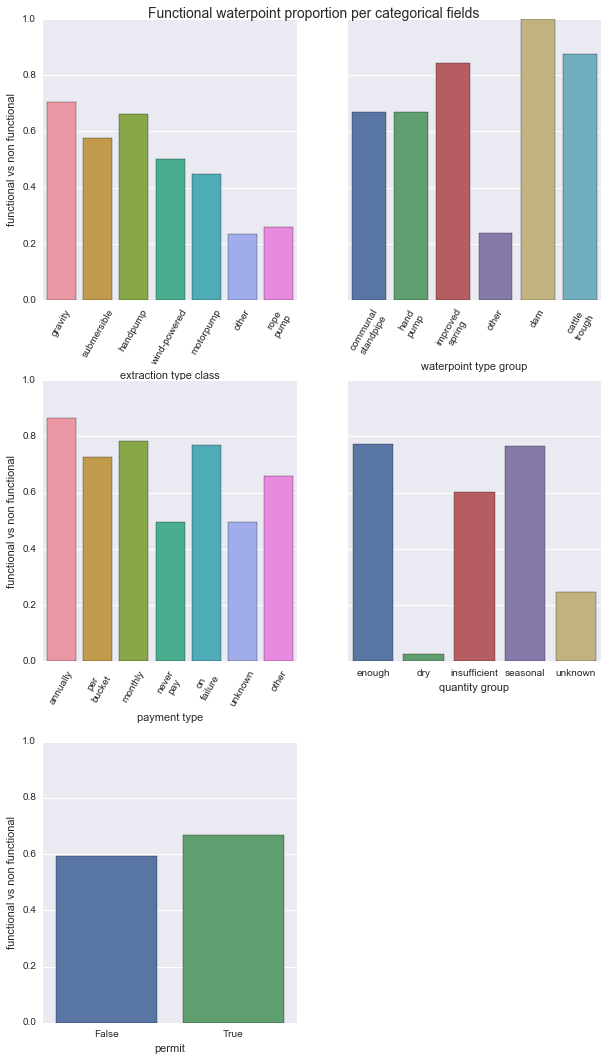

In [96]:
fig, axes = plt.subplots(3, 2, 
                         sharey=True, 
                         gridspec_kw=dict(hspace=0.285), 
                         figsize=(10, 16.5))
axes = axes.ravel()

for i, field in enumerate(('extraction_type_class', 'waterpoint_type_group', 'payment_type', 
                           'quantity_group', 'permit')):

    field_name = ' '.join(field.split('_'))
        
    var_analysis = clean_data[['status_group', 'functional', 'no_repairs', field]]

    ax = sns.barplot(x=field, y='functional', data=var_analysis, ci=None, ax=axes[i])
    ax.set_xlabel(field_name)
    if i % 2 == 0:
        ax.set_ylabel('functional vs non functional')
    else:
        ax.set_ylabel('')
    lbls = ['\n'.join(l.get_text().split()) for l in ax.get_xticklabels()]
    if len(lbls) > 5:
        ax.set_xticklabels(lbls, rotation=60)

axes[5].set_visible(False)        

fig.suptitle('Functional waterpoint proportion per categorical fields', fontsize=14)
plt.subplots_adjust(top=0.97)
plt.show();

To visualize the influence of the quantitative variables on the functional status 
of the waterpoints, the quantitative variables have been collapsed in two bins the median value being the separation.

Using chi-square test, all variables have a significant relationship with the response variable.
Waterpoints with an higher altitude are more likely to be functional (p-value = 2e-57). Those more in the eastern side of Tanzania have a lesser chance to be functional (p-value = 0.003). The waterpoints constructed after 2000 are in better functional condition (p-value = 0). And those sustaining an higher population tend to be less functional (p-value = 2.5e-13).

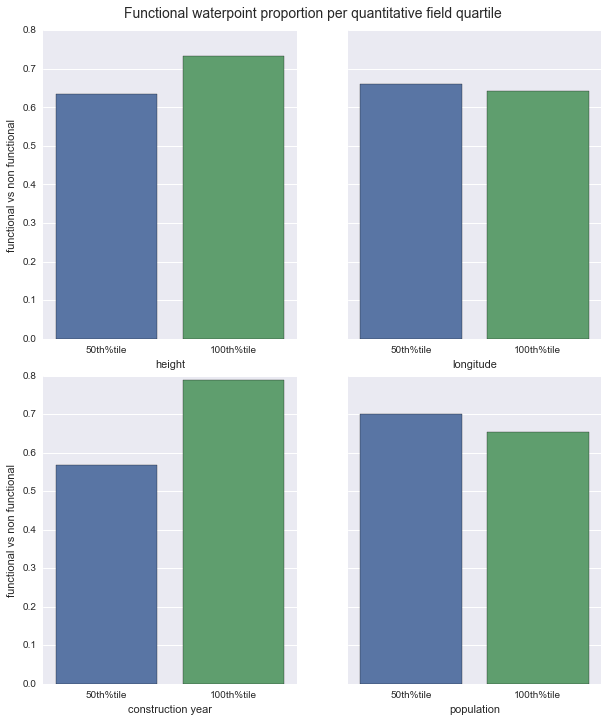

In [99]:
fig, axes = plt.subplots(2, 2, 
                         sharey=True, 
                         gridspec_kw=dict(hspace=0.12), 
                         figsize=(10, 11))
axes = axes.ravel()

for i, field in enumerate(('gps_height', 'longitude', 'construction_year', 'population')):
    if field == 'gps_height':
        field_name = 'height'
    else:
        field_name = ' '.join(field.split('_'))
        
    var_analysis = clean_data[['status_group', 'functional', 'no_repairs']]
    clean_field = clean_data[field].map(lambda x: x if abs(x)>1e-8 else pd.np.nan)
    var_analysis = var_analysis.join(clean_field).dropna()
    
    var_analysis[field+'grp2'] = pd.qcut(var_analysis[field], 
                                         2,
                                         labels=["50th%tile", 
                                                 "100th%tile"])
#                                          4,
#                                          labels=["25th%tile", "50th%tile", 
#                                                  "75th%tile", "100th%tile"])

    ax = sns.barplot(x=field+'grp2', y='functional', data=var_analysis, ci=None, ax=axes[i])
    ax.set_xlabel(field_name)
    if i % 2 == 0:
        ax.set_ylabel('functional vs non functional')
    else:
        ax.set_ylabel('')

fig.suptitle('Functional waterpoint proportion per quantitative field quartile', fontsize=14)
plt.subplots_adjust(top=0.95)
plt.show();

### Random Forest Test

With the subset of explanatory variables selected, we can split the data to estimate the number of trees needed to stabilise the accuracy. By taking 60% of the available data as training set, the accuracy of the Random Forest test stabilizes for a number of trees superior to 23 as shown in the figure below.

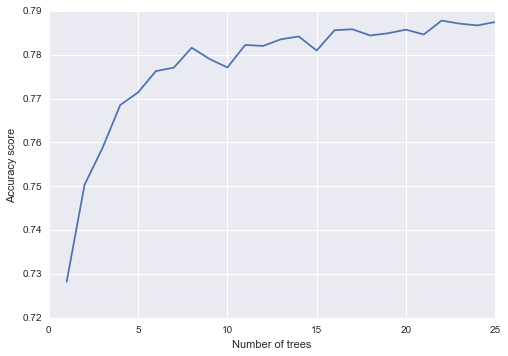

In [41]:
pd.np.random.seed(12345)
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, 
                                                              deployed_data['status_group'], 
                                                              test_size=.4)

trees=range(1, 26)
accuracy=pd.np.zeros(25)

for idx in range(len(trees)):
   classifier=RandomForestClassifier(n_estimators=idx + 1)
   classifier=classifier.fit(pred_train,tar_train)
   predictions=classifier.predict(pred_test)
   accuracy[idx]=accuracy_score(tar_test, predictions)
   
plt.plot(trees, accuracy)
plt.xlabel("Number of trees")
plt.ylabel("Accuracy score")
plt.show();

So I run a Random Forest test with 25 trees with all training data and submitted on DrivenData.org the resulting prediction. I got a score of 76.86%. That score is a bit frustrating as the majority of the people reach 80%. So I'll work hard during the last week to improve the results.

> This Jupyter notebook will be the basis for the final report for the [Data Analysis and Interpretation Specialization](https://www.coursera.org/specializations/data-analysis)

In [25]:
!jupyter nbconvert --to html --template full_nice WaterPumpsPrediction.ipynb

[NbConvertApp] Converting notebook WaterPumpsPrediction.ipynb to html
[NbConvertApp] Writing 261378 bytes to WaterPumpsPrediction.html
